# Exploratory Data Analysis (EDA)

## Packages

In [85]:
import json
import logging
import os
import warnings

import dspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from matplotlib.ticker import FuncFormatter
from openai import OpenAI

# Suppress all warnings
warnings.filterwarnings("ignore")

## Data Loading

In [86]:
# Read dataset
df = pd.read_csv("../data/train_df.csv")

In [87]:
df.head()

,ds_name,split,id,context,question,options,correct_answer
0,logiqa,train,0,"Some Cantonese don't like chili, so some south...",Which of the following can guarantee the above...,"['Some Cantonese love chili.', 'Some people wh...",2
1,logiqa,train,1,Continuous exposure to indoor fluorescent ligh...,Which of the following questions was the initi...,['Can hospital light therapy be proved to prom...,0
2,logiqa,train,2,There is no doubt that minors should be prohib...,"In order to evaluate the above argument, which...",['Does the proportion of underage smokers in t...,1
3,logiqa,train,3,A research report states that a special educat...,Which of the following best illustrates the lo...,"[""Children's cognitive abilities are constantl...",0
4,logiqa,train,4,"The traitor is a traitor, so you are a traitor...",Which of the following makes the same logical ...,['Literature and art are not worthy of attenti...,2


## Data Inspection

### Dataset: `logiqa`
- **Context:** Some Cantonese don't like chili, so some southerners don't like chili.
- **Question:** Which of the following can guarantee the above argument?
- **Options:** 
  - 'Some Cantonese love chili.'
  - 'Some people who like peppers are southerners.'
  - 'All Cantonese are southerners.'
  - 'Some Cantonese like neither peppers nor sweets.'
- **Correct Answer Index:** 2

---

### Dataset: `commonsense_qa`
- **Context:** nan
- **Question:** The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
- **Options:** 
  - 'ignore'
  - 'enforce'
  - 'authoritarian'
  - 'yell at'
  - 'avoid'
- **Correct Answer Index:** 0

---

### Dataset: `quail`
- **Context:** That fall came and I went back to Michigan and the school year went by and summer came and I never really thought about it. I'm not even sure if I was officially asked, I just wound up heading back to New Jersey when school was out. I think my parents thought it was a good enough deal. They were already having some problems and without Nonna there anymore to take care of me I think my cousin's house on the coast seemed like as good a spot as any to stick me for the summer. It certainly wasn't because of any great love between me and my cousin. We weren't really very good friends at that point. I think she saw me as sort of foisted off on her and getting in the way of her summers. Which was a fair enough judgment. But she could have been nicer. It's pretty amazing that she wound up as my Maid of Honor. Time does strange things. Your lovable jack-ass of a father would mention something about magic in here. You know if you took a group of fifty strangers, had them chat with your father for half an hour then with me for half an hour, then told them that one of us was an English Professor and one of us was head of distribution in the northeast for a large soft drink manufacturing concern, I'm pretty sure all fifty would peg your father as the English Professor and me as the head of distribution. He's honestly so good at what he does that I can almost allow him to claim it's magic except that it'd be nice if he took credit for some of the things he's done with his life. Of course he has this idea that he deserves credit for all sorts of things that he had no control over. Like our first kiss.
- **Question:** Why was this character sent away after each school year?
- **Options:** 
  - 'not enough information'
  - 'to visit family'
  - 'parents had problems'
  - 'for tutoring'
- **Correct Answer Index:** 3

---

### Dataset: `mathqa`
- **Context:** nan
- **Question:** the banker ' s gain of a certain sum due 3 years hence at 10 % per annum is rs . 36 . what is the present worth ?
- **Options:** 
  - 'rs . 400'
  - 'rs . 300'
  - 'rs . 500'
  - 'rs . 350'
  - 'none of these'
- **Correct Answer Index:** 0


## Summary Statistics

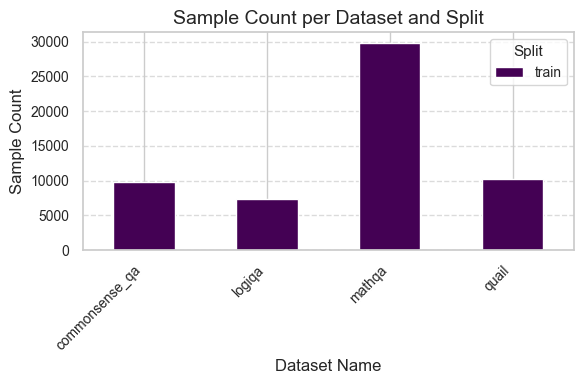

In [88]:
# Check if the resulting DataFrame is empty
if count_per_dataset.empty:
    print("No data available to plot.")
else:
    # Plotting with a smaller figure size
    ax = count_per_dataset.plot(
        kind="bar", stacked=False, figsize=(6, 4), colormap="viridis"
    )  # Smaller size

    # Customize plot appearance
    plt.title(
        "Sample Count per Dataset and Split", fontsize=14
    )  # Slightly smaller title font size
    plt.xlabel("Dataset Name", fontsize=12)
    plt.ylabel("Sample Count", fontsize=12)
    plt.xticks(
        rotation=45, ha="right", fontsize=10
    )  # Slightly smaller x-tick font size
    plt.yticks(fontsize=10)  # Slightly smaller y-tick font size
    plt.legend(title="Split", title_fontsize="11", fontsize="10", loc="upper right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add grid for better readability
    plt.tight_layout()  # Adjust layout for better spacing

    # Show plot
    plt.show()

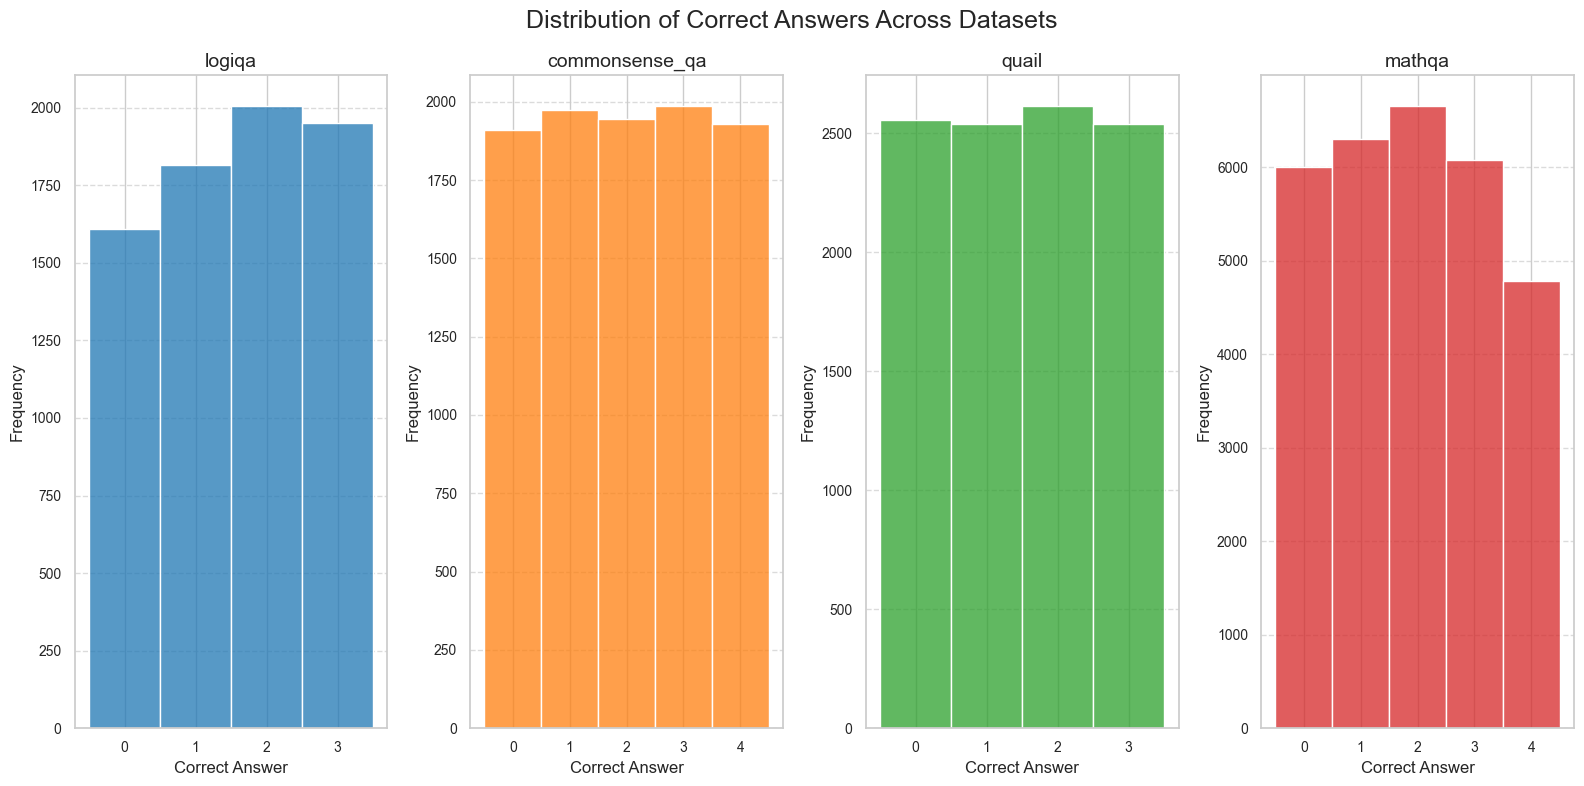

In [89]:
datasets = df["ds_name"].unique()  # Get unique dataset names

# Define a list of colors for each subplot
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Create a figure with a 1x4 grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 8))
axes = axes.flatten()
fig.suptitle("Distribution of Correct Answers Across Datasets", fontsize=18)

# Loop through datasets and plot the distribution of correct answers
for i, ds in enumerate(datasets):
    if i < len(axes):
        # Set bins based on the dataset name
        if ds in ["commonsense_qa", "mathqa"]:
            bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]  # 5 bins
        else:
            bins = [-0.5, 0.5, 1.5, 2.5, 3.5]  # 4 bins

        sns.histplot(
            df[df["ds_name"] == ds]["correct_answer"],
            bins=bins,  # Define bin edges
            ax=axes[i],
            color=colors[i],
        )
        axes[i].set_title(f"{ds}", fontsize=14)
        axes[i].set_xlabel("Correct Answer", fontsize=12)
        axes[i].set_ylabel("Frequency", fontsize=12)
        axes[i].tick_params(axis="both", labelsize=10)
        axes[i].grid(axis="y", linestyle="--", alpha=0.7)

        # Set x-ticks to only show integers (0, 1, 2, 3, 4)
        if ds in ["commonsense_qa", "mathqa"]:
            axes[i].set_xticks([0, 1, 2, 3, 4])
        else:
            axes[i].set_xticks([0, 1, 2, 3])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

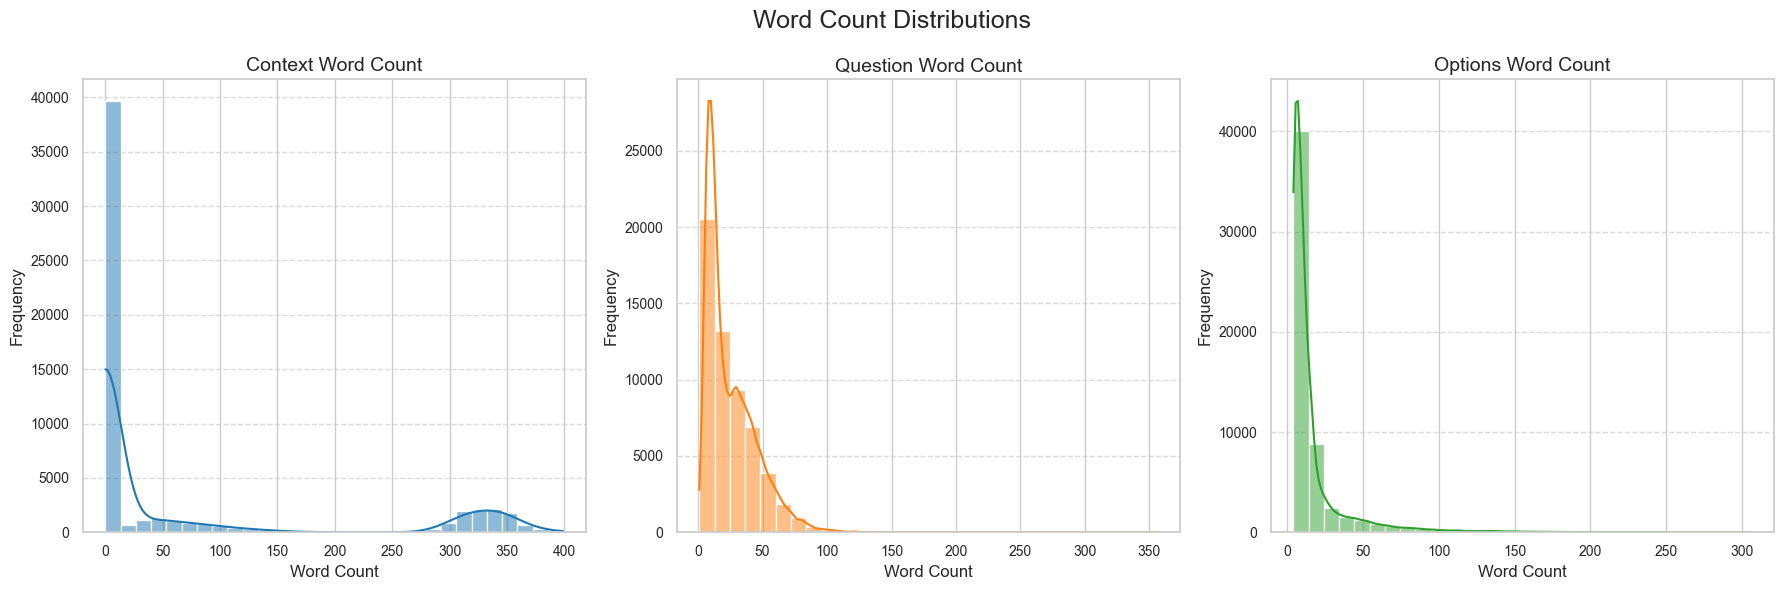

In [90]:
def count_words(text):
    if isinstance(text, str):
        return len(text.split())
    return 0  # Return 0 for non-string types


# Create new columns for word counts
df["context_word_count"] = df["context"].apply(count_words)
df["question_word_count"] = df["question"].apply(count_words)
df["options_word_count"] = df["options"].apply(
    lambda x: (
        sum(count_words(option) for option in x.split(";")) if isinstance(x, str) else 0
    )
)

# Prepare for plotting
word_count_columns = ["context_word_count", "question_word_count", "options_word_count"]
word_count_labels = ["Context Word Count", "Question Word Count", "Options Word Count"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Create a figure with a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Word Count Distributions", fontsize=18)


# Function to format y-axis tick labels
def normal_format(x, pos):
    return f"{int(x)}"  # Format as an integer


# Loop through the word count columns and plot
for i, column in enumerate(word_count_columns):
    sns.histplot(df[column], bins=30, ax=axes[i], color=colors[i], kde=True)
    axes[i].set_title(word_count_labels[i], fontsize=14)
    axes[i].set_xlabel("Word Count", fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)
    axes[i].tick_params(axis="both", labelsize=10)
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

    # Apply the normal formatting to the y-axis
    axes[i].yaxis.set_major_formatter(FuncFormatter(normal_format))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()